In [1]:
from utils_me import *
from fastai2.vision.widgets import *

## Scraping Data from web

In [2]:
path = Path('/notebooks/storage/Handwash_project')

In [3]:
key = 'xxx'

In [45]:
search_results =  search_images_bing(key, term = 'wash basin', count = 100)+search_images_bing(key, term = 'wash basin top', count = 135) + search_images_bing(key, term = 'wash basin top view', count = 135)
search_results

(#370) [<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d9190>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d91d0>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d9290>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d9350>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d9410>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d9590>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d95d0>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d9690>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x7f69243d9750>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object a

In [46]:
dest = path/'Wash_basin'
if not dest.exists():
    dest.mkdir()
download_images(dest,urls = search_results.attrgot('content_url'))

In [47]:
failed_images= verify_images(get_image_files(path/'Wash_basin')) ## Removing images that are invalid
failed_images

(#29) [Path('/notebooks/storage/Handwash_project/Wash_basin/00000177.jpg'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000054.jpg'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000183.jpg'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000228.jpg'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000080.jpg'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000166.jpg'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000012.jpg'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000106.jpg'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000091.JPG'),Path('/notebooks/storage/Handwash_project/Wash_basin/00000319.jpg')...]

In [48]:
failed_images.map(Path.unlink)


(#29) [None,None,None,None,None,None,None,None,None,None...]

In [54]:
Path(path/'Handwash').ls()

(#143) [Path('/notebooks/storage/Handwash_project/Handwash/00000118.jpg'),Path('/notebooks/storage/Handwash_project/Handwash/00000083.jpg'),Path('/notebooks/storage/Handwash_project/Handwash/00000116.jpg'),Path('/notebooks/storage/Handwash_project/Handwash/00000066.jpg'),Path('/notebooks/storage/Handwash_project/Handwash/00000078.jpg'),Path('/notebooks/storage/Handwash_project/Handwash/00000020.jpg'),Path('/notebooks/storage/Handwash_project/Handwash/00000053.jpeg'),Path('/notebooks/storage/Handwash_project/Handwash/00000067.jpg'),Path('/notebooks/storage/Handwash_project/Handwash/00000054.jpg'),Path('/notebooks/storage/Handwash_project/Handwash/00000111.jpg')...]

## Run the deep learning model

In [10]:
dls = DataBlock(blocks = (ImageBlock,CategoryBlock),
                get_y = parent_label,
                splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
                get_items = get_image_files
               )

In [11]:
dls = dls.new(item_tfms = RandomResizedCrop(size = 224),
                batch_tfms = aug_transforms()
               )


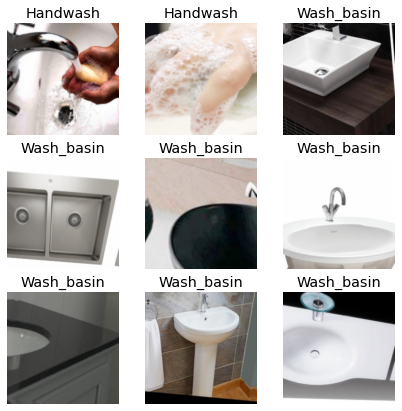

In [12]:
wash = dls.dataloaders(path)
wash.show_batch(figsize=(7,7))

In [13]:
learn = cnn_learner(wash,resnet34,metrics=error_rate)
learn.fine_tune(3)   ## Tuning resnet34

epoch,train_loss,valid_loss,error_rate,time
0,0.862940,0.183674,0.090909,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.263781,0.106425,0.034091,00:05
1,0.190340,0.089730,0.022727,00:05
2,0.139458,0.020976,0.011364,00:05


In [14]:
interp = ClassificationInterpretation.from_learner(learn)

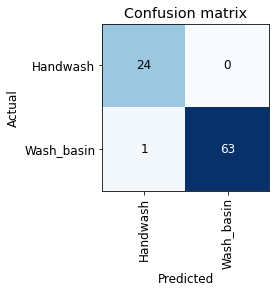

In [15]:
interp.plot_confusion_matrix()

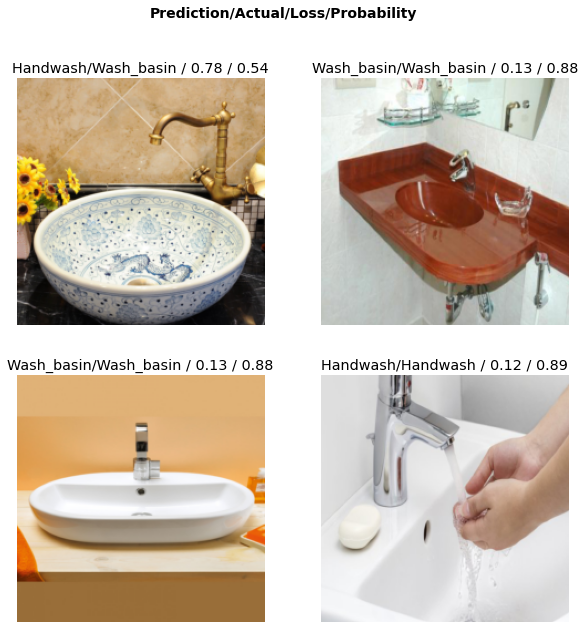

In [16]:
interp.plot_top_losses(k=4, figsize = (10,10))

### Clean the image dataset using the model

In [ ]:
cleaner = ImageClassifierCleaner(learn)  ##Cleaning the dataset using the model we trained for better accuracy
cleaner

In [110]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [85]:
learn.export('handwash1.pkl')

In [20]:
learn_use = load_learner('handwash2.pkl')

## Model for production that can be run using voila

In [21]:
upld_button = widgets.FileUpload()
pred_label = widgets.Label()
out = widgets.Output()

In [22]:
btn_clasify = widgets.Button()

def on_click_classify(change):
    img= PILImage.create(upld_button.data[-1])
    wash,index,probabilities  = learn_use.predict(img)
    with out:
        display(img.to_thumb(256,256))
    
    if(wash == 'Handwash'):
        pred_label.value = f'This is great! You are washing hands and predicted with probability {probabilities[index]}'
        
    else:
        pred_label.value = f'You are not washing hands and predicted with probability {probabilities[index]}'
        
upld_button.observe(on_click_classify,names = ['data'])

In [23]:
vb = widgets.VBox([upld_button,out,pred_label])
display(vb)

In [78]:
upld_button1.class_trait_names()

['_counter',
 '_display_callbacks',
 '_dom_classes',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_msg_callbacks',
 '_property_lock',
 '_states_to_send',
 '_view_count',
 '_view_module',
 '_view_module_version',
 '_view_name',
 'accept',
 'button_style',
 'comm',
 'data',
 'description',
 'description_tooltip',
 'disabled',
 'error',
 'icon',
 'keys',
 'layout',
 'log',
 'metadata',
 'multiple',
 'style',
 'value']

In [76]:
doc(upld_button1.has_trait)

In [15]:
import cv2  ##Test for using a video for input

# Opens the Video file
cap = cv2.VideoCapture(0)
i=0
cap.open(0)
print(cap.isOpened())
while(cap.isOpened()):
    ret, frame = cap.read()
    
    if ret == False:
        break
    cv2.imwrite('/notebooks/storage/Handwash_project/jang'+str(i)+'.jpg',frame)
    i+=1

cap.release()
cv2.destroyAllWindows()

False


In [ ]:
for j in range(0,i//3):
        
       
        try :
            img  = PILImage.create('/notebooks/storage/Handwash_project/kang'+str(j)+'.jpg')
            wash,index,probabilities  = learn_use.predict(img)
        except FileNotFoundError:
            continue
        if(wash == 'Handwash'):
            print(f'{j} - This is great! You are washing hands and predicted with probability {probabilities[index]}')
        else:
            print(f'{j} - You are not washing hands and predicted with probability {probabilities[index]}')

0 - You are not washing hands and predicted with probability 0.9948337078094482


1 - You are not washing hands and predicted with probability 0.9944424033164978


2 - You are not washing hands and predicted with probability 0.996467113494873


3 - You are not washing hands and predicted with probability 0.9963472485542297


4 - You are not washing hands and predicted with probability 0.9976680874824524


5 - You are not washing hands and predicted with probability 0.9973068237304688


6 - You are not washing hands and predicted with probability 0.9961686730384827


7 - You are not washing hands and predicted with probability 0.9902617335319519


8 - You are not washing hands and predicted with probability 0.9876948595046997


9 - You are not washing hands and predicted with probability 0.9889194369316101


10 - You are not washing hands and predicted with probability 0.9917691946029663


11 - You are not washing hands and predicted with probability 0.9969033598899841


12 - You are not washing hands and predicted with probability 0.9981366395950317


13 - You are not washing hands and predicted with probability 0.9979416728019714


14 - You are not washing hands and predicted with probability 0.9977337121963501


15 - You are not washing hands and predicted with probability 0.9977723956108093


16 - You are not washing hands and predicted with probability 0.997212827205658


17 - You are not washing hands and predicted with probability 0.9962258338928223


18 - You are not washing hands and predicted with probability 0.994758665561676


19 - You are not washing hands and predicted with probability 0.9955431818962097


20 - You are not washing hands and predicted with probability 0.994462788105011


21 - You are not washing hands and predicted with probability 0.9933405518531799


22 - You are not washing hands and predicted with probability 0.9941452741622925


23 - You are not washing hands and predicted with probability 0.9961963891983032


24 - You are not washing hands and predicted with probability 0.9960317015647888


25 - You are not washing hands and predicted with probability 0.9955464601516724


26 - You are not washing hands and predicted with probability 0.9961722493171692


27 - You are not washing hands and predicted with probability 0.9959684610366821


28 - You are not washing hands and predicted with probability 0.9948199391365051


29 - You are not washing hands and predicted with probability 0.9956949949264526


30 - You are not washing hands and predicted with probability 0.9962437152862549


31 - You are not washing hands and predicted with probability 0.9959633350372314


32 - You are not washing hands and predicted with probability 0.9945336580276489


33 - You are not washing hands and predicted with probability 0.994184672832489


34 - You are not washing hands and predicted with probability 0.9949106574058533


35 - You are not washing hands and predicted with probability 0.9936949610710144


36 - You are not washing hands and predicted with probability 0.9916198253631592


37 - You are not washing hands and predicted with probability 0.9910871386528015


38 - You are not washing hands and predicted with probability 0.9932243227958679


39 - You are not washing hands and predicted with probability 0.9942816495895386


40 - You are not washing hands and predicted with probability 0.9955263733863831


41 - You are not washing hands and predicted with probability 0.9967769980430603


42 - You are not washing hands and predicted with probability 0.9967603087425232


43 - You are not washing hands and predicted with probability 0.9972819089889526


44 - You are not washing hands and predicted with probability 0.9971502423286438


45 - You are not washing hands and predicted with probability 0.9965517520904541


46 - You are not washing hands and predicted with probability 0.996353268623352


47 - You are not washing hands and predicted with probability 0.9961458444595337


48 - You are not washing hands and predicted with probability 0.9948375821113586


49 - You are not washing hands and predicted with probability 0.9952523708343506


50 - You are not washing hands and predicted with probability 0.9960108995437622


51 - You are not washing hands and predicted with probability 0.9955717325210571


52 - You are not washing hands and predicted with probability 0.9947309494018555


53 - You are not washing hands and predicted with probability 0.99604731798172


54 - You are not washing hands and predicted with probability 0.9957681894302368


55 - You are not washing hands and predicted with probability 0.995222270488739


56 - You are not washing hands and predicted with probability 0.9957373142242432


57 - You are not washing hands and predicted with probability 0.9959006905555725


58 - You are not washing hands and predicted with probability 0.9966351389884949


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe07d7a97a0>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_workers
    w.join()
  File "/opt/conda/envs/fastai/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe07d7a97a0>
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 961, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/fastai/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 941, in _shutdown_w

59 - You are not washing hands and predicted with probability 0.9889103174209595


60 - You are not washing hands and predicted with probability 0.9892428517341614


61 - You are not washing hands and predicted with probability 0.989787220954895


62 - You are not washing hands and predicted with probability 0.9853315353393555


63 - You are not washing hands and predicted with probability 0.9863371253013611


64 - You are not washing hands and predicted with probability 0.9663090109825134


65 - You are not washing hands and predicted with probability 0.9704813361167908


66 - You are not washing hands and predicted with probability 0.979842483997345


67 - You are not washing hands and predicted with probability 0.9829680323600769


68 - You are not washing hands and predicted with probability 0.9836607575416565


69 - You are not washing hands and predicted with probability 0.9658199548721313


70 - You are not washing hands and predicted with probability 0.9834567904472351


71 - You are not washing hands and predicted with probability 0.9976235032081604


72 - You are not washing hands and predicted with probability 0.9978587031364441


73 - You are not washing hands and predicted with probability 0.9961680769920349


74 - You are not washing hands and predicted with probability 0.9890385866165161


75 - You are not washing hands and predicted with probability 0.9951964020729065


76 - You are not washing hands and predicted with probability 0.9914501309394836


77 - You are not washing hands and predicted with probability 0.9866997003555298


78 - You are not washing hands and predicted with probability 0.9890372157096863


79 - You are not washing hands and predicted with probability 0.9904824495315552


80 - You are not washing hands and predicted with probability 0.9944679737091064


81 - You are not washing hands and predicted with probability 0.9875345230102539


82 - You are not washing hands and predicted with probability 0.9253466725349426


83 - You are not washing hands and predicted with probability 0.9499569535255432


84 - You are not washing hands and predicted with probability 0.9939424395561218


85 - You are not washing hands and predicted with probability 0.9967942833900452


86 - You are not washing hands and predicted with probability 0.9896945953369141


87 - You are not washing hands and predicted with probability 0.973788321018219


88 - You are not washing hands and predicted with probability 0.9191093444824219


89 - You are not washing hands and predicted with probability 0.9334656596183777


90 - You are not washing hands and predicted with probability 0.985217273235321


91 - You are not washing hands and predicted with probability 0.990714430809021


92 - You are not washing hands and predicted with probability 0.9559269547462463


93 - You are not washing hands and predicted with probability 0.9796174168586731


94 - You are not washing hands and predicted with probability 0.9677608609199524


95 - You are not washing hands and predicted with probability 0.9924587607383728


96 - You are not washing hands and predicted with probability 0.9651687741279602


97 - You are not washing hands and predicted with probability 0.9750070571899414


98 - You are not washing hands and predicted with probability 0.9228725433349609


99 - You are not washing hands and predicted with probability 0.9655371308326721


100 - You are not washing hands and predicted with probability 0.9060173630714417


101 - You are not washing hands and predicted with probability 0.9470133185386658


102 - You are not washing hands and predicted with probability 0.953465461730957


103 - You are not washing hands and predicted with probability 0.9747583866119385


104 - You are not washing hands and predicted with probability 0.9360074400901794


105 - You are not washing hands and predicted with probability 0.9701026082038879


106 - You are not washing hands and predicted with probability 0.8550865054130554


107 - You are not washing hands and predicted with probability 0.7202857732772827


108 - You are not washing hands and predicted with probability 0.8447920680046082


109 - You are not washing hands and predicted with probability 0.9142980575561523


110 - You are not washing hands and predicted with probability 0.9353545904159546


111 - You are not washing hands and predicted with probability 0.8476691246032715


112 - You are not washing hands and predicted with probability 0.9395082592964172


113 - You are not washing hands and predicted with probability 0.9866558313369751


114 - You are not washing hands and predicted with probability 0.9333169460296631


115 - This is great! You are washing hands and predicted with probability 0.5960055589675903


116 - You are not washing hands and predicted with probability 0.594942033290863


117 - You are not washing hands and predicted with probability 0.7735856175422668


118 - You are not washing hands and predicted with probability 0.8005834817886353


119 - You are not washing hands and predicted with probability 0.8956502079963684


120 - You are not washing hands and predicted with probability 0.9635133147239685


121 - You are not washing hands and predicted with probability 0.9366271495819092


122 - You are not washing hands and predicted with probability 0.8111814260482788


123 - You are not washing hands and predicted with probability 0.9846783876419067


124 - You are not washing hands and predicted with probability 0.9958963394165039


125 - You are not washing hands and predicted with probability 0.9892270565032959


126 - You are not washing hands and predicted with probability 0.9972341656684875


127 - You are not washing hands and predicted with probability 0.9941806197166443


128 - You are not washing hands and predicted with probability 0.9804093837738037


129 - You are not washing hands and predicted with probability 0.9866423606872559


130 - You are not washing hands and predicted with probability 0.9937615990638733


131 - You are not washing hands and predicted with probability 0.9855912923812866


132 - You are not washing hands and predicted with probability 0.9519786238670349


133 - You are not washing hands and predicted with probability 0.9707661867141724


134 - You are not washing hands and predicted with probability 0.9710191488265991


135 - You are not washing hands and predicted with probability 0.9883530735969543


136 - You are not washing hands and predicted with probability 0.9808886647224426


137 - You are not washing hands and predicted with probability 0.9602547883987427


138 - You are not washing hands and predicted with probability 0.9935687780380249


139 - You are not washing hands and predicted with probability 0.9544547200202942


140 - You are not washing hands and predicted with probability 0.9685314893722534


141 - You are not washing hands and predicted with probability 0.9841429591178894


142 - You are not washing hands and predicted with probability 0.9762338995933533


143 - You are not washing hands and predicted with probability 0.9597334861755371


144 - You are not washing hands and predicted with probability 0.966559648513794


145 - You are not washing hands and predicted with probability 0.9827156066894531


146 - You are not washing hands and predicted with probability 0.9758603572845459


147 - You are not washing hands and predicted with probability 0.9740868210792542


148 - You are not washing hands and predicted with probability 0.9733874201774597


149 - You are not washing hands and predicted with probability 0.9708154797554016


150 - You are not washing hands and predicted with probability 0.8870486617088318


151 - You are not washing hands and predicted with probability 0.9553835988044739


152 - You are not washing hands and predicted with probability 0.9569499492645264


153 - You are not washing hands and predicted with probability 0.9744748473167419


154 - You are not washing hands and predicted with probability 0.9726063013076782


155 - You are not washing hands and predicted with probability 0.9785817265510559


156 - You are not washing hands and predicted with probability 0.9775945544242859


157 - You are not washing hands and predicted with probability 0.9925917387008667


158 - You are not washing hands and predicted with probability 0.9922441840171814


159 - You are not washing hands and predicted with probability 0.9905835390090942


160 - You are not washing hands and predicted with probability 0.9871588945388794


161 - You are not washing hands and predicted with probability 0.9726516604423523


162 - You are not washing hands and predicted with probability 0.9602212309837341


163 - You are not washing hands and predicted with probability 0.9583487510681152


164 - You are not washing hands and predicted with probability 0.953689694404602


165 - You are not washing hands and predicted with probability 0.9366323947906494


166 - You are not washing hands and predicted with probability 0.8995001316070557


167 - You are not washing hands and predicted with probability 0.8865142464637756


168 - You are not washing hands and predicted with probability 0.9130973219871521


169 - You are not washing hands and predicted with probability 0.9661540985107422


170 - You are not washing hands and predicted with probability 0.9273303151130676


171 - You are not washing hands and predicted with probability 0.976844847202301


172 - You are not washing hands and predicted with probability 0.9546087384223938
